# Install packages if necessary

In [ ]:
# %pip install git+https://github.com/huggingface/transformers
# %pip install fair-esm
# %pip install datasets
# %pip install accelerate -U
# %pip install absl-py
# %pip install -U scikit-learn pandas matplotlib seaborn transformers tensorflow evaluate ipywidgets git-lfs
# %pip install torch torchvision torchaudio wandb pytorch_lightning
# source of esm : https://pypi.org/project/fair-esm/

# Import modules

In [ ]:
import numpy as np
import socket
import shutil
from absl import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay,roc_curve, roc_auc_score, auc, precision_recall_curve,f1_score,PrecisionRecallDisplay
import sys
import os
import pandas as pd
import functools
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch 
from transformers import AutoTokenizer
from datasets import Dataset
from huggingface_hub import notebook_login
import wandb
from pytorch_lightning.loggers import WandbLogger
print(f"pytorch version: {torch.__version__}")
print(f"Python version: {sys.version}")
print(f"Executable path: {sys.executable}")
print(f"Hostname: {socket.gethostname}")
print(f"current working directory: {os.getcwd()}")


## Fine tune a pre-trained model

In [ ]:
#wandb.login()
wandb_logger = WandbLogger()

In [ ]:
#notebook_login()

### Examples

In [ ]:
### PyTorch : https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb
## source on how to fine tune a pre-trained model using huggingface: https://huggingface.co/docs/transformers/training

### Tensorflow: https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling-tf.ipynb

In [ ]:
model_checkpoint = "facebook/esm2_t12_35M_UR50D"
#model_checkpoint ="facebook/esm2_t33_650M_UR50D"

### Sequence classification

### Data preparation

In [ ]:
def process_df(df):
    """This function takes a dataframe and returns two seperate lists of sequences and labels"""
    
    df = df[['sequence','is_viable']] # only keep the sequences and labels
    df.loc[:,'sequence'] = df['sequence'].apply(lambda x: x.upper()) # convert to upper case
    ## convert to string type .
    # ## Otherwise, it gives an error during tokenization "ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
    sequences = df['sequence'].apply(lambda x: str(x))
    sequences = sequences.tolist()
    labels = df['is_viable']
    labels = labels.apply(lambda x: 1 if x==True else 0) # convert to binary numbers (0 and 1)
    labels = labels.tolist() # convert data type to list 
    
    return sequences, labels

In [ ]:
def tokenize_add_label(sequences, labels, tokenizer):
    """This function takes sequences and labels creates a Dataset containing tokenized sequences and add labels to it
       
       args:
           sequences (str): a list of sequences
           labels (int): a list of labels
           tokenizer : a pre-trained tokenizer
        
       return: 
            Dataset: tokenized sequences and associated labels)"""
    sequences_tokenized = tokenizer(sequences,padding=True,truncation=True)
    sequences_dataset = Dataset.from_dict(sequences_tokenized)
    sequences_dataset = sequences_dataset.add_column("labels", labels)

    return sequences_dataset

In [ ]:
#df = pd.read_csv('allseqs_20191230.csv')
df = pd.read_csv('c1r2_seq.csv')
# df = df.iloc[0:50,:]
df.head()

In [ ]:
sequences, labels = process_df(df)

## Split the data into train,test, and validation sets

In [ ]:
train_sequences, test_valid_sequences, train_labels, test_valid_labels = train_test_split(sequences, labels, test_size=0.20, shuffle=True)

test_sequences,valid_sequences, test_labels,valid_labels = train_test_split(test_valid_sequences,test_valid_labels,test_size=0.4,shuffle=True)


In [ ]:
print(f" number of sequences in the train set: {len(train_sequences)} | with number of labels = {len(train_labels)} ")
print(f" number of sequences in the validation set: {len(valid_sequences)} | with number of labels = {len(valid_labels)} ")

## Tokenize the data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
tokenizer(train_sequences[0:10])

In [ ]:
train_dataset = tokenize_add_label(train_sequences, train_labels, tokenizer)
test_dataset = tokenize_add_label(test_sequences, test_labels, tokenizer)
valid_dataset = tokenize_add_label(valid_sequences, valid_labels, tokenizer)
train_dataset

# Load model

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = max(train_labels + valid_labels) +1  # Add 1 since 0 can be a label
print(f"number of classes or labels = {num_labels}")
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels) # load the pre-trained model

In [ ]:
model.get_output_embeddings

In [ ]:
# model_name = model_checkpoint.split("/")[-1]
# batch_size = 5
# args = TrainingArguments(
#     f"{model_name}-finetuned-model_esm-2_on_aav",
#     evaluation_strategy = "steps",#save_strategy = "steps",
#     learning_rate=2e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     push_to_hub=False,report_to="wandb") # Turn the push_to_hub=True if you load the model after trainging to the hub 

In [ ]:
model_name = model_checkpoint.split("/")[-1]
trainer_dir = f"{model_name}-finetuned-model_esm-2_on_clr2-aav"
batch_size = 5
args = TrainingArguments(
    output_dir=trainer_dir,
    overwrite_output_dir = True,
    evaluation_strategy = "steps",#save_strategy = "steps",
    learning_rate=2e-5,
    logging_steps=100,
    eval_steps=5000,
    save_steps=10000,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,report_to="wandb") # Turn the push_to_hub=True if you load the model after trainging to the hub 

In [ ]:
# wandb.init(project="esm_1b_finetune_with_aav",
#            config={
#                "batch_size": 10,
#                "learning_rate": 2e-5,
#            })

In [ ]:
from evaluate import load

metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # labels = labels.unsqueeze(1)
    # predictions = predictions.unsqueeze(1)
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


In [ ]:
wandb_logger = WandbLogger(project="esm-2_finetuning_aav",
                           log_model='all')

In [ ]:
# run = wandb.init(project="esm-2-finetuning_aav",
#                  config={"batch_size": 10,
#                          "learning_rate": 2e-5,
#                          "dataset": "clr2"})

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# run the model in GPU

In [ ]:
print(f"PyTorch version: {torch.__version__}")
# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device to GPU (mps)
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print(f"Using device: {device}")

In [ ]:
# set the model to GPU : device="mps"
model.to(device)

In [ ]:
model.config.problem_type

In [ ]:

trainer.train()

In [ ]:
trainer.state.log_history

In [ ]:
# run.finish()
wandb.finish()

In [ ]:
# trainer.evaluate(test_dataset)

# Perform prediction on test data to check the performance

In [ ]:
def trainer_predict(dataset,trainer):
    """This function takes a dataset (tokenized sequences and labels) and a trained model (Trainer module from huggingface)
    and returns a list of predicted labels
    
    args:
        dataset (tokenized data): sequences and labels
        trainer (Trainer class): Trainer with filled args
    return:
        true labels (int): actual labels
        predicted_labels(int): inferred labels by the Trainer """
    
    print(f"currently performing predictions of labels on a dataset of {len(dataset)} sequences")
    predicted_results = trainer.predict(dataset)
    predicted_labels = np.argmax(predicted_results.predictions,axis=-1).tolist()
    true_labels = predicted_results.label_ids
    true_labels = true_labels.tolist()
    
    scores = predicted_results.predictions
    
    return true_labels, predicted_labels, scores


## create a roc curve

In [ ]:
def create_roc_curve(true_labels,predicted_labels,scores,filename=None):
    """This function takes true and predicted labels, scores, and creates a roc curve"""
    
    # convert list to array data type
    if not isinstance(scores, np.ndarray):
        scores = np.array(scores)

    fig = plt.figure()
    # from sklearn.metrics import RocCurveDisplay
    from sklearn.metrics import roc_curve, roc_auc_score, auc
    fpr,tpr,threshold = roc_curve(true_labels, scores[::,1]) # input the positive scores (label:1) only as it is required for roc_curve (ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
    AUC = auc(fpr,tpr)
    roc_display = RocCurveDisplay(fpr=fpr,tpr=tpr, roc_auc=AUC, estimator_name='Binary classifier').plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0,1], [0,1], 'k--',)
    if filename is not None:
        save_file = f"roc_fine_tuned_{filename}.png"
        plt.savefig(save_file,dpi=300)
    plt.show()

In [357]:
def plot_precision_recall_curve(true_labels,predicted_labels,scores,filename=None,display=1):
    """This function takes true and predicted labels, scores, and creates a precision-recall curve.

       Note, if there is a significant class imbalance in the dataset, it is recommended to use the precison-recall curve rather than ROC curve
       to evaluate model's performance.
       ref: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
            https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/
    """
    

     # convert list to array data type
    if not isinstance(scores, np.ndarray):
        scores = np.array(scores)
        
    fig = plt.figure()
    # from sklearn.metrics import RocCurveDisplay
    from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve,f1_score,PrecisionRecallDisplay
    precision,recall,_ = precision_recall_curve(predicted_labels, scores[::,1]) # input the positive scores (label:1) only as it is required for roc_curve (ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)
    f1,AUC = f1_score(true_labels,predicted_labels),auc(recall,precision)
    # plot the curve (https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#:~:text=The%20precision%2Drecall%20curve%20shows,a%20low%20false%20negative%20rate.)

    if display == 0:
        disp = PrecisionRecallDisplay(precision=precision, recall=recall,plot_chance_level=True)# ref (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)
        disp.plot()
    elif display==1:   
        disp = PrecisionRecallDisplay.from_predictions(predicted_labels, scores[::,1], name="Binary Classifier", plot_chance_level=True) #ref: (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)
        _ = disp.ax_.set_title("Binary-class Precision-Recall curve")
    else:
        ## plot the no skill precision-recall curve
        # calculate the no skill line as the proportion of the positive class
        true_labels = np.array(true_labels)
        no_skill = len(true_labels[true_labels==1]) / len(true_labels)
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        plt.plot(recall, precision, marker='.', label='Binary Classifier')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()

    if filename is not None:
        save_file = f"precision_recall_curve_fine_tuned_{filename}.png"
        plt.savefig(save_file,dpi=300)
    plt.show()

In [349]:
true_labels, predicted_labels,scores = trainer_predict(test_dataset,trainer)

currently performing predictions of labels on a dataset of 3004 sequences


<Figure size 640x480 with 0 Axes>

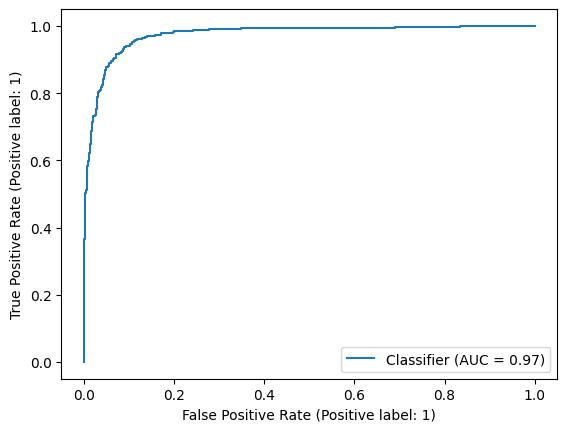

<Figure size 640x480 with 0 Axes>

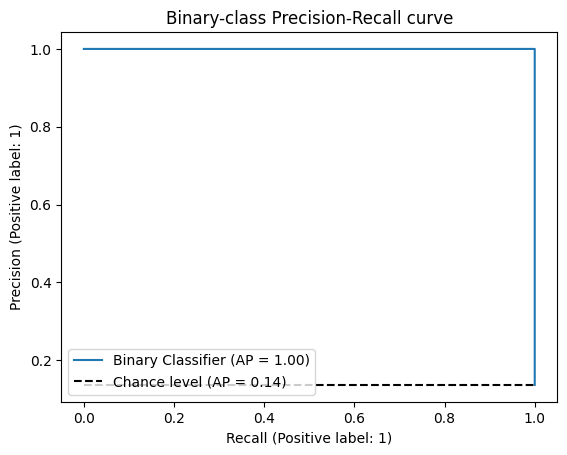

In [380]:
file_save = f"esm-2_on_clr2_{len(true_labels)}_test_seq_data"
create_roc_curve_label(true_labels, predicted_labels,scores,file_save)
plot_precision_recall_curve(true_labels, predicted_labels,scores,file_save)


# Test model's performance on a different dataset

In [359]:
df_all_seq = pd.read_csv('allseqs_20191230.csv')
num_peps = 10000
random_pep_index = sorted(np.random.randint(0,len(df_all_seq),num_peps))
df_all_seq = df_all_seq.iloc[random_pep_index,:]
df_all_seq.reset_index(drop=True,inplace=True)
df_all_seq

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable
5,ADEEIRTTNPVATEQYGSVSTNPvQRGNR,designed,AD____________________Pv_____,4,4,-1.815227,False
13,ADMEIIQVNPYSSEQYGDCATPLYHGTG,designed,ADM__IQV__YSS____DCA_P_YH_TG,17,17,-5.116514,False
47,ADTIIVTTNTVATEIYGCVgAeMNLQPLIP,designed,ADTI_V___T____I__C_gAeM___PLIP,16,16,-4.156943,False
71,AEAEITATNCCSTECYGNVdDsEgPpGvDcDmEdDlF,designed,A_A__TA__CCS__C__N_dDsEgPpGvDcDmEdDlF,27,26,-5.839737,False
73,AEAEITTTNPVSTEQYGSVSTNLQVGNR,designed,A_A__T_____S____________V___,5,5,1.015606,True
...,...,...,...,...,...,...,...
296819,YlEEEIRTTNPVATEQYGSVSDmNLsQRGNaN,lr_rand_doubles_plus_single_seed,Yl___________________Dm__s____aN,7,7,-5.501083,False
296855,YnEkEEdIwFTNtNDVAIEIYGHVmSIgNLlQQGNRf,lr_designed_plus_rand_train_seed,Yn_k__d_wF_Nt_D__I_I__H_m_Ig__l_Q___f,18,18,-7.129635,False
296919,YvETEIGTnTNNCAiTEcQIiGTVcVaLaIQeEvRpTQeEe,cnn_rand_doubles_plus_single_walked,Yv_T__G_n__NC_i__c_Ii_T_cVaLaIQeEv_pTQeEe,28,26,-4.691514,False
296956,nDEEEIRTTNPVATEQYGSVSTNLQRGNR,singles,n____________________________,1,1,-4.848826,False


In [360]:
# process and prepare data
seq_all,seq_all_labels = process_df(df_all_seq)
seq_all_dataset = tokenize_add_label(seq_all,seq_all_labels,tokenizer)
# true_seq_all_labels = [x['labels'] for x in seq_all_dataset] # extract true labels from the dataset
seq_all_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})

In [362]:
true_seq_all_labels , predicted_labels_seq_all, scores_all = trainer_predict(seq_all_dataset,trainer)

currently performing predictions of labels on a dataset of 10000 sequences


  0%|          | 0/2000 [00:00<?, ?it/s]

In [379]:
#df_all_save = pd.concat([pd.DataFrame(true_seq_all_labels),pd.DataFrame(predicted_labels_seq_all)],axis=1)
predicted_labels_df = pd.concat([pd.DataFrame(true_seq_all_labels), pd.DataFrame(predicted_labels_seq_all)], axis=1)
predicted_labels_df.columns = ['true_label','predicted_label']
df_all_seq.reset_index(drop=True,inplace=True)
df_all_save = pd.concat([df_all_seq, predicted_labels_df],axis=1)
df_all_save.to_csv('all_seq_10k_true_vs_predicted_labels.csv',index=False)
df_all_save

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable,true_label,predicted_label
0,ADEEIRTTNPVATEQYGSVSTNPvQRGNR,designed,AD____________________Pv_____,4,4,-1.815227,False,0,1
1,ADMEIIQVNPYSSEQYGDCATPLYHGTG,designed,ADM__IQV__YSS____DCA_P_YH_TG,17,17,-5.116514,False,0,0
2,ADTIIVTTNTVATEIYGCVgAeMNLQPLIP,designed,ADTI_V___T____I__C_gAeM___PLIP,16,16,-4.156943,False,0,0
3,AEAEITATNCCSTECYGNVdDsEgPpGvDcDmEdDlF,designed,A_A__TA__CCS__C__N_dDsEgPpGvDcDmEdDlF,27,26,-5.839737,False,0,0
4,AEAEITTTNPVSTEQYGSVSTNLQVGNR,designed,A_A__T_____S____________V___,5,5,1.015606,True,1,1
...,...,...,...,...,...,...,...,...,...
9995,YlEEEIRTTNPVATEQYGSVSDmNLsQRGNaN,lr_rand_doubles_plus_single_seed,Yl___________________Dm__s____aN,7,7,-5.501083,False,0,0
9996,YnEkEEdIwFTNtNDVAIEIYGHVmSIgNLlQQGNRf,lr_designed_plus_rand_train_seed,Yn_k__d_wF_Nt_D__I_I__H_m_Ig__l_Q___f,18,18,-7.129635,False,0,0
9997,YvETEIGTnTNNCAiTEcQIiGTVcVaLaIQeEvRpTQeEe,cnn_rand_doubles_plus_single_walked,Yv_T__G_n__NC_i__c_Ii_T_cVaLaIQeEv_pTQeEe,28,26,-4.691514,False,0,0
9998,nDEEEIRTTNPVATEQYGSVSTNLQRGNR,singles,n____________________________,1,1,-4.848826,False,0,0


<Figure size 640x480 with 0 Axes>

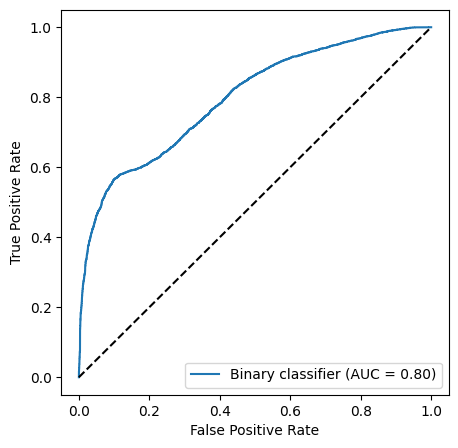

<Figure size 640x480 with 0 Axes>

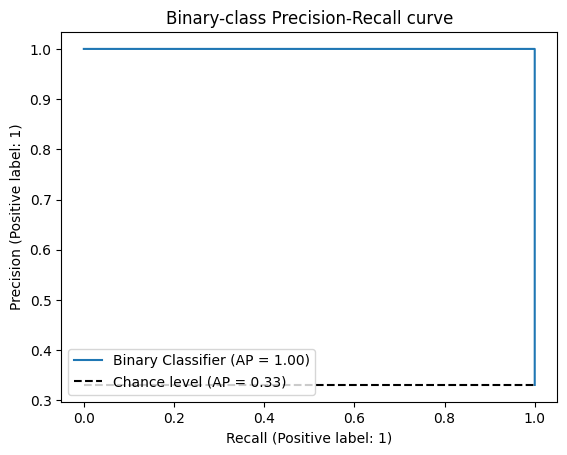

In [364]:
file_save = f"esm-2_on_clr2_{len(true_seq_all_labels)}_all_seq_data_10k"
create_roc_curve(true_seq_all_labels, predicted_labels_seq_all,scores_all,file_save)
plot_precision_recall_curve(true_seq_all_labels, predicted_labels_seq_all,scores_all,file_save)

# Save the fine_tuned model and tokenizer

In [ ]:
# model_dir = os.path.join(os.getcwd(),'fine_tuned_esm_aav')
# trainer.save_model(model_dir)
# alternative method to save a model (fine-tuned)
# model.save_pretrained(model_dir)

### save the trainer

In [ ]:
trainer_dir = os.path.join(os.getcwd(),'fine_tuned_esm-2_with_clr2_aav_Trainer')
trainer.save_model(trainer_dir)

### save the trained model

In [ ]:
#model.eval()
pretrained_model_name = model_checkpoint.split('/')[1]
model_dir = os.path.join(os.getcwd(),f"{pretrained_model_name}_fine_tuned_with_clr2_aav_data")
print(f"saving the trained model in the directory: {model_dir}")
model.save_pretrained(model_dir)

### save the tokenizer

In [ ]:
tokenizer_dir = os.path.join(os.getcwd(),f"{pretrained_model_name}_fine_tuned_with_clr2_aav_tokenizer")
print(f"saving the tokenizer in the directory: {model_dir}")
tokenizer.save_pretrained(model_dir)

# Perform predictions using the fine-tuned model (using Huggingface Trainer API)


Here, loading of a Tokenizer is not needed. But the input sequences must be tokenized before.

### Initiate Trainer() and perform inference

In [ ]:
pred_arg = TrainingArguments(
    output_dir=trainer_dir,
    do_train=False,
    do_predict=True,
    per_device_eval_batch_size=batch_size,
    dataloader_drop_last=False)

In [ ]:
# load the model and input the arguments to the Trainer class
trainer_model = AutoModelForSequenceClassification.from_pretrained(trainer_dir) # load the fine tuned pre-trained model
trainer_model.to(device) # assign to GPU if it exists
loaded_trainer = Trainer(model=trainer_model,args=pred_arg,compute_metrics=compute_metrics)

In [ ]:
true_labels, predicted_labels = trainer_predict(test_dataset,loaded_trainer)
file_save = f"esm-2_on_clr2_{len(true_labels)}_test_seq_data"
create_roc_curve(true_labels, predicted_labels,file_save)

# Perform predictions using the fine-tuned model (using HuggingFace pipeline API)

Here, Tokenizer must be loaded and the input sequences should not be tokenized.

In [ ]:
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained(model_dir) 
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_dir) # load the fine tuned pre-trained model
loaded_model.to(device) # submit it to GPU: device='MPS' for mac , device='CUDA' for NVIDIA
clf = pipeline("text-classification",loaded_model,tokenizer=tokenizer,return_all_scores=True,batch_size=batch_size,device=device) # return_all_scores=True if it is binary classification task

In [ ]:
def model_predict(dataset,model):
    """This function takes a dataset (tokenized sequences and labels) and a trained model (Trainer module from huggingface)
    and returns a list of predicted labels
    
    args:
        dataset (str): sequences
        model: a fine-tuned model
    return:
        predicted_labels(int): a list of inferred labels by the Trainer """
    
    print(f"currently performing predictions of labels on a dataset of {len(dataset)} sequences")
    predicted_results = model.predict(dataset)

    scores = [[x[0]['score'],x[1]['score']] for x in predicted_results]
    # scores = []
    # for x in model_predicted:
    #     print(f"score for label 0: {x[0]['score']}")
    #     print(f"score for label 1: {x[1]['score']}")
    #     label_0_score = x[0]['score']
    #     label_1_score = x[1]['score']
    #     scores.append([label_0_score, label_1_score])

    predicted_labels = np.argmax(scores,axis=-1).tolist()

    
    return predicted_labels,scores


In [ ]:
predicted_labels_model,scores = model_predict(test_sequences,clf)
true_labels = test_labels
predicted_labels_model

In [ ]:
file_save = f"esm-2_on_clr2_{len(true_labels)}_seq_data"
create_roc_curve(true_labels, predicted_labels_model,scores)
plot_precision_recall_curve(true_labels, predicted_labels_model,scores)